<a href="https://colab.research.google.com/github/enakai00/rl_book_solutions/blob/master/Chapter07/Exercise_7_2_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7.2 : Solution

In [0]:
import numpy as np
from numpy import random
from pandas import DataFrame

In [0]:
class Car:
  def __init__(self, x=0, y=3):
    self.path = []
    self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0),
                    (1, 1), (1, -1), (-1, -1), (-1, 1)]
    self.episodes = [0]
    self.q = {}
    self.v = {}
    self.restart(x, y)

  def restart(self, x=0, y=3):
    self.x, self.y = x, y
    self.path = []

  def get_state(self):
    return self.x, self.y

  def show_path(self):
    result = [[' ' for x in range(10)] for y in range(7)]
    for c, (x, y, a) in enumerate(self.path):
      result[y][x] = str(c)[-1]
    result[3][7] = 'G'
    return result     

  def add_episode(self, c=0):
    self.episodes.append(self.episodes[-1]+c)

  def move(self, action, noise):
    self.path.append((self.x, self.y, action))
    vx, vy = self.actions[action]
    if self.x >= 3 and self.x <= 8:
      vy -= 1
    if self.x >= 6 and self.x <= 7:
      vy -= 1
    if noise:
      vy += random.randint(3) - 1

    _x, _y = self.x + vx, self.y + vy
    if _x < 0 or _x > 9:
      _x = self.x
    if _y < 0 or _y > 6:
      _y = self.y
    self.x, self.y = _x, _y
    if (self.x, self.y) == (7, 3): # Finish
      return True

    return False

In [0]:
def get_action(car, epsilon, num_actions=4):
  if random.random() < epsilon:
    a = random.randint(0, num_actions)
  else:
    a = optimal_action(car, num_actions)
  return a

def optimal_action(car, num_actions):
  optimal = 0
  v_max = -999999
  initial = True
  x, y = car.get_state()
  for a in range(num_actions):
    _car = Car(x, y)
    finished = _car.move(a, noise=False)
    _x, _y = _car.get_state()
    s = "{:02},{:02}".format(_x, _y)
    if s not in car.v.keys():
      car.v[s] = 0
    v = car.v[s]
    if initial or v > v_max:
      v_max = v
      optimal = a
      initial = False
  return optimal

def update_v(car, states, td_errors, drain=False, delta=False):
  alpha = 0.1
  if not delta:
    s1 = states[0]
    s2 = states[-1]
    if s1 not in car.v.keys():
      car.v[s1] = 0
    if s2 not in car.v.keys():
      car.v[s2] = 0
    r = -1 * (len(states)-1)
    car.v[s1] += alpha * (r + car.v[s2] - car.v[s1])
    if drain:
      states.pop(0)
      td_errors.pop(0)
      if len(states) == 1:
        return
      update_v(car, states, td_errors, drain=True, delta=False)
  else:
    s1 = states[0]
    if s1 not in car.v.keys():
      car.v[s1] = 0
    car.v[s1] += alpha * np.sum(td_errors)
    if drain:
      states.pop(0)
      td_errors.pop(0)
      if len(states) == 1:
        return
      update_v(car, states, td_errors, drain=True, delta=True)

def trial(car, epsilon = 0.1, king=False, noise=False, steps=5, delta=False):
  num_actions = 4
  if king:
    num_actions = 8
  car.restart()
  states = []
  td_errors = []
  running = True
  x, y = car.get_state()
  s_pre = "{:02},{:02}".format(x, y)
  states.append(s_pre)

  while True:
    a = get_action(car, epsilon, num_actions)
    finished = car.move(a, noise)
    x, y = car.get_state()
    s_new = "{:02},{:02}".format(x, y)
    states.append(s_new)
    if s_pre not in car.v.keys():
      car.v[s_pre] = 0
    if s_new not in car.v.keys():
      car.v[s_new] = 0
    td_errors.append(-1 + car.v[s_new] - car.v[s_pre])
    if finished:      
      car.add_episode(1)
      update_v(car, states, td_errors, drain=True, delta=delta)
      break
    car.add_episode(0)
    s_pre = s_new
    if len(states) >= steps + 1:
      update_v(car, states, td_errors, drain=False, delta=delta)
      td_errors.pop(0)
      states.pop(0)


Compare TD[n] and 'TD Error sum' method with n=10, α=10.

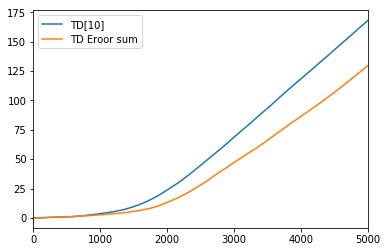

In [4]:
result1 = np.zeros(5001)
for _ in range(50):
  car1 = Car()
  while True:
    trial(car1, noise=False, steps=10, delta=False)
    if len(car1.episodes) > 5000:
      break
  result1 += np.array(car1.episodes[:5001])

result2 = np.zeros(5001)
for _ in range(50):
  car2 = Car()
  while True:
    trial(car2, noise=False, steps=10, delta=True)
    if len(car2.episodes) > 5000:
      break
  result2 += np.array(car2.episodes[:5001])

DataFrame({'TD[10]': result1/50,
           'TD Eroor sum': result2/50,
           }).plot()

Find the optimal n with α=0.1

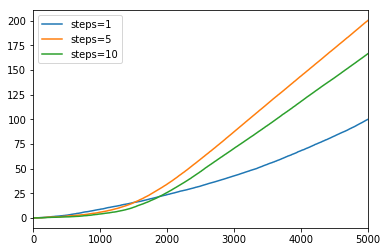

In [5]:
result1 = np.zeros(5001)
for _ in range(50):
  car1 = Car()
  while True:
    trial(car1, noise=False, steps=1, delta=False)
    if len(car1.episodes) > 5000:
      break
  result1 += np.array(car1.episodes[:5001])

result2 = np.zeros(5001)
for _ in range(50):
  car2 = Car()
  while True:
    trial(car2, noise=False, steps=5, delta=False)
    if len(car2.episodes) > 5000:
      break
  result2 += np.array(car2.episodes[:5001])

result3 = np.zeros(5001)
for _ in range(50):
  car3 = Car()
  while True:
    trial(car3, noise=False, steps=10, delta=False)
    if len(car3.episodes) > 5000:
      break
  result3 += np.array(car3.episodes[:5001])

DataFrame({'steps=1': result1/50,
           'steps=5': result2/50,
           'steps=10': result3/50,
           }).plot()